# Model Comparison (No pmdarima)

In [25]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error




In [26]:
df = pd.read_csv("weatherHistory.csv")

# Force to UTC while parsing
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True, errors='coerce')

# Remove timezone -> naive datetime
df['Formatted Date'] = df['Formatted Date'].dt.tz_localize(None)

# Set as index
df = df.set_index('Formatted Date').sort_index()
cols = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
        'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)']
df = df[cols].resample('D').mean().ffill().asfreq('D')
series = df['Temperature (C)']
train, test = series[-3*365:], series[-365:]
exog = df[['Humidity','Pressure (millibars)']].fillna(method='ffill')
train_exog, test_exog = exog[-3*365:], exog[-365:]


C:\Users\Ruchir Mangal\AppData\Local\Temp\ipykernel_14208\2029587627.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog = df[['Humidity','Pressure (millibars)']].fillna(method='ffill')


## SARIMAX (fixed orders)

In [27]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
order = (2,1,2)
seasonal_order = (1,1,1,30)

sarimax = SARIMAX(train, order=order, seasonal_order=seasonal_order, exog=train_exog,
                 enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
sarimax_fore = sarimax.get_forecast(steps=len(test), exog=test_exog).predicted_mean
sarimax_mae = mean_absolute_error(test, sarimax_fore); sarimax_rmse = np.sqrt(mean_squared_error(test, sarimax_fore))
print('SARIMAX MAE, RMSE:', sarimax_mae, sarimax_rmse)


c:\New folder (2)\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX MAE, RMSE: 11.537054556583938 13.499534731698642


## Prophet

In [28]:

from prophet import Prophet
prophet_df = train.reset_index().rename(columns={'Formatted Date':'ds','Temperature (C)':'y'})
prophet_df['ds'] = prophet_df['ds'].dt.tz_localize(None)
m = Prophet(yearly_seasonality=True, daily_seasonality=False)
m.fit(prophet_df)
future = m.make_future_dataframe(periods=len(test))
forecast_prophet = m.predict(future).set_index('ds')['yhat'][-len(test):]
prophet_mae = mean_absolute_error(test, forecast_prophet); prophet_rmse = np.sqrt(mean_squared_error(test, forecast_prophet))
print('Prophet MAE, RMSE:', prophet_mae, prophet_rmse)


22:30:48 - cmdstanpy - INFO - Chain [1] start processing
22:30:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE, RMSE: 2.2403546013377356 2.97271835917264


## Random Forest (lag features)

In [29]:

ml_df = series.to_frame().copy()
for lag in range(1,8):
    ml_df[f'lag_{lag}'] = ml_df['Temperature (C)'].shift(lag)
ml_df['dayofyear'] = ml_df.index.dayofyear
ml_df = ml_df.dropna()

X = ml_df.drop('Temperature (C)', axis=1); y = ml_df['Temperature (C)']
X_train, X_test = X[:-365], X[-365:]; y_train, y_test = y[:-365], y[-365:]


In [30]:

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_pred); rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
print('RF MAE, RMSE:', rf_mae, rf_rmse)


RF MAE, RMSE: 1.5080543796216848 1.9852949518117593


## XGBoost (optional)

In [31]:

try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(n_estimators=200, random_state=42, verbosity=0)
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_mae = mean_absolute_error(y_test, xgb_pred); xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
    print('XGBoost MAE, RMSE:', xgb_mae, xgb_rmse)
except Exception as e:
    print('XGBoost not available:', e)


XGBoost MAE, RMSE: 1.6746884071872956 2.1991374513335167


## LSTM (if trained model exists)

In [32]:

import os
if os.path.exists('lstm_model.h5') and os.path.exists('scaler.save'):
    from tensorflow.keras.models import load_model
    import joblib
    model = load_model('lstm_model.h5',compile=False)
    scaler = joblib.load('scaler.save')
    data = scaler.transform(df)
    SEQ = 30
    X_all = []
    for i in range(len(data)-SEQ):
        X_all.append(data[i:i+SEQ])
    X_all = np.array(X_all)
    X_test_lstm = X_all[-len(test):]
    y_pred = model.predict(X_test_lstm)
    temp_pred = np.hstack([y_pred.reshape(-1,1), np.zeros((len(y_pred), data.shape[1]-1))])
    lstm_pred = scaler.inverse_transform(temp_pred)[:,0]
    lstm_mae = mean_absolute_error(test, lstm_pred); lstm_rmse = np.sqrt(mean_squared_error(test, lstm_pred))
    print('LSTM MAE, RMSE:', lstm_mae, lstm_rmse)
else:
    print('LSTM model not found - run LSTM notebook first.')


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
LSTM MAE, RMSE: 1.9126801790252712 2.370539687683674


## Summary and plot

                 MAE    RMSE
SARIMAX       11.537  13.500
Prophet        2.240   2.973
RandomForest   1.508   1.985
XGBoost        1.675   2.199
LSTM           1.913   2.371


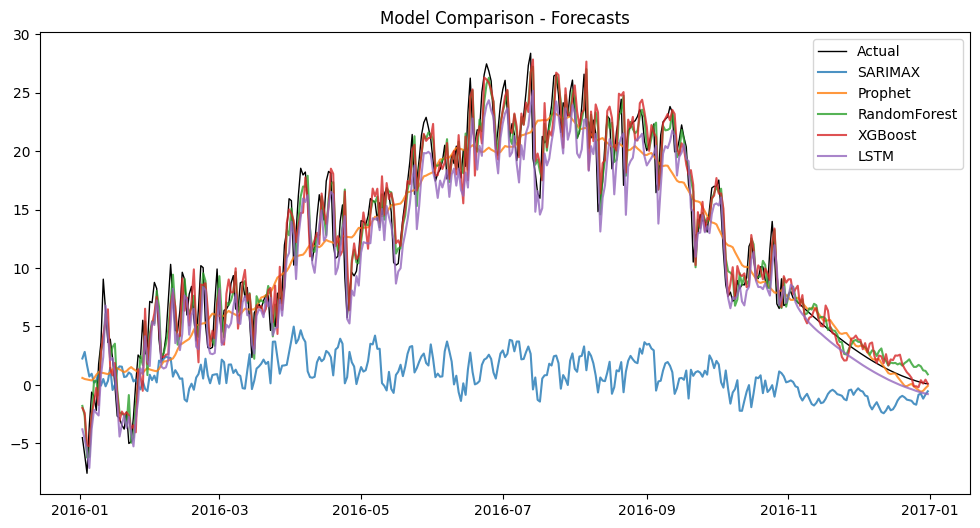

In [33]:

results = {'SARIMAX': (sarimax_mae, sarimax_rmse), 'Prophet': (prophet_mae, prophet_rmse), 'RandomForest': (rf_mae, rf_rmse)}
try:
    results['XGBoost'] = (xgb_mae, xgb_rmse)
except:
    pass
if 'lstm_pred' in globals():
    results['LSTM'] = (lstm_mae, lstm_rmse)

import pandas as pd
res_df = pd.DataFrame.from_dict(results, orient='index', columns=['MAE','RMSE']).round(3)
print(res_df)

plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual', color='k', linewidth=1)
plt.plot(test.index, sarimax_fore, label='SARIMAX', alpha=0.8)
plt.plot(test.index, forecast_prophet, label='Prophet', alpha=0.8)
plt.plot(test.index, rf_pred, label='RandomForest', alpha=0.8)
try:
    plt.plot(test.index, xgb_pred, label='XGBoost', alpha=0.8)
except:
    pass
if 'lstm_pred' in globals():
    plt.plot(test.index, lstm_pred, label='LSTM', alpha=0.8)
plt.legend(); plt.title('Model Comparison - Forecasts'); plt.show()
